In [4]:
!pip install yfinance --quiet

In [1]:
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.18.1
GPU Available: []


In [2]:
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2025-09-10"


In [3]:
df = yf.download(ticker, start=start_date, end=end_date)


C:\Users\uzair\AppData\Local\Temp\ipykernel_19332\3882796689.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [4]:
df = df[['Close']].dropna()


In [5]:
df.head()


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.261047
2015-01-05,23.577574
2015-01-06,23.579790
2015-01-07,23.910435
2015-01-08,24.829124


#Preprocessing

In [6]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)
# Normalizes prices between 0 and 1 (LSTM trains better on normalized values).

In [7]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])   # sequence of past 'seq_len' days
        y.append(data[i+seq_len])     # the value right after the sequence
    return np.array(X), np.array(y)


In [8]:
SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)


In [9]:
X = X.reshape((X.shape[0], X.shape[1], 1))


In [10]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [11]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2101, 60, 1) (2101, 1)
Test shape: (526, 60, 1) (526, 1)


#Build RNN LSTM model

In [12]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])


c:\Users\uzair\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [14]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

#Train model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[es],
    verbose=1
)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 0.0144 - mae: 0.0712 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0012 - mae: 0.0219 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 9.9408e-04 - mae: 0.0193 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0011 - mae: 0.0201 - val_loss: 0.0014 - val_mae: 0.0296
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 9.4983e-04 - mae: 0.0190 - val_loss: 0.0019 - val_mae: 0.0357
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 9.3967e-04 - mae: 0.0189 - val_loss: 0.0010 - val_mae: 0.0248
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 9.0820e-04 - mae: 0.0189 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 9.5351e-04 - mae: 0.0189 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80m

#Evaluate the model

In [17]:
pred_scaled = model.predict(X_test)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [18]:
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1,1))


In [19]:
rmse = math.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
print("RMSE:", rmse, "MAE:", mae)


RMSE: 7.607158252703911 MAE: 5.890213157740836


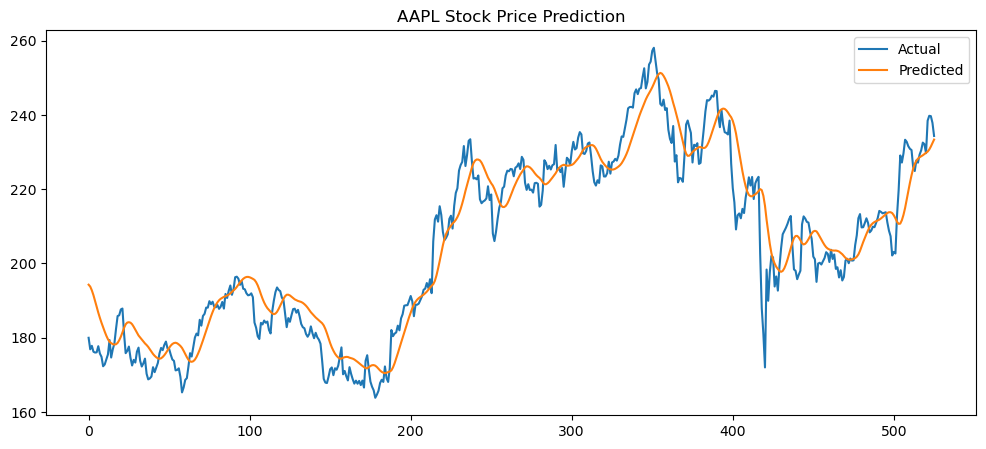

In [20]:
plt.figure(figsize=(12,5))
plt.plot(actual, label="Actual")
plt.plot(pred, label="Predicted")
plt.title(f"{ticker} Stock Price Prediction")
plt.legend()
plt.show()


#Forecast feature values

In [21]:
N_DAYS = 7
last_seq = scaled[-SEQ_LEN:]   # last 60 days data
current_seq = last_seq.copy()
future_preds = []


In [22]:
for _ in range(N_DAYS):
    pred_scaled = model.predict(current_seq.reshape(1, SEQ_LEN, 1))[0]
    future_preds.append(pred_scaled)
    current_seq = np.append(current_seq[1:], pred_scaled.reshape(1, 1), axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [23]:
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
print(f"Next {N_DAYS} days prediction:")
print(future_preds.flatten())


Next 7 days prediction:
[234.09398 234.6083  234.96515 235.20541 235.36261 235.46259 235.524  ]
